# Disclaimer:
+ This script was adapted from the NBIS Tutorial Single-Cell RNA Seg Analysis
+ https://nbisweden.github.io/workshop-scRNAseq/labs/

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import scrublet as scr

In [ ]:
# Ignore warnings + set sc settings
warnings.simplefilter(action='ignore', category=Warning)

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

In [ ]:
# Read in the data
path_results = '2_DimensionalityReduction/Data/Output'
path_file = '2_DimensionalityReduction/Data/Input/scanpy_qc_scAtlas.h5ad'

adata = sc.read_h5ad(path_file)

# Subset the dataset to only include Mononuclear Phagocytes and Plasmacytoid Dendritic Cells
adata = adata[adata.obs['author_first_cell_type'].isin(['Mononuclear Phagocytes','Plasmacytoid Dendritic Cells'])]

In [ ]:
# Add computed variables into the original dataset to perform the following steps
# Predict doublets
# Split per batch into new objects
batches = adata.obs['cell_type'].cat.categories.tolist()
alldata = {}
for batch in batches:
    tmp = adata[adata.obs['cell_type'] == batch,]
    print(batch, ':', tmp.shape[0], ' cells')
    scrub = scr.Scrublet(tmp.raw.X)
    out = scrub.scrub_doublets(verbose=False, n_prin_comps = 10)
    alldata[batch] = pd.DataFrame({'doublet_score':out[0],'predicted_doublets':out[1]},index = tmp.obs.index)
    print(alldata[batch].predicted_doublets.sum(), ' predicted_doublets')

# Add predictions to the adata object
scrub_pred = pd.concat(alldata.values())
adata.obs['doublet_scores'] = scrub_pred['doublet_score'] 
adata.obs['predicted_doublets'] = scrub_pred['predicted_doublets'] 

# Add in column with singlet/doublet instead of True/False
#%matplotlib inline

adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

# Revert back to the raw counts as the main matrix in adata
adata = adata.raw.to_adata() 

mononuclear phagocyte : 51636  cells
25  predicted_doublets
plasmacytoid dendritic cell : 1361  cells
1  predicted_doublets


In [ ]:
# Normalize to a depth 10 000
sc.pp.normalize_total(adata, target_sum=1e4)

# log transform
sc.pp.log1p(adata)

# Store the normalized counts in the raw slot
adata.raw = adata

normalizing counts per cell


    finished (0:00:00)


AnnData object with n_obs × n_vars = 52997 × 45454
    obs: 'nCount_RNA', 'nFeature_RNA', 'harm_study', 'harm_healthy.tissue', 'harm_tumor.site', 'harm_sample.type', 'harm_condition', 'harm_tumor.type', 'harm_cd45pos', 'harm_healthy.pat', 'percent.mt', 'ratio_nCount_nFeature', 'batch', 'X_scvi_batch', 'X_scvi_labels', 'X_scvi_local_l_mean', 'X_scvi_local_l_var', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_1', 'leiden_1.2', 'leiden_1.4', 'author_first_cell_type', 'author_cell_type', 'cnv_score', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'assay_ontology_term_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'doublet_scores', 'predicted_doublets

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 4108


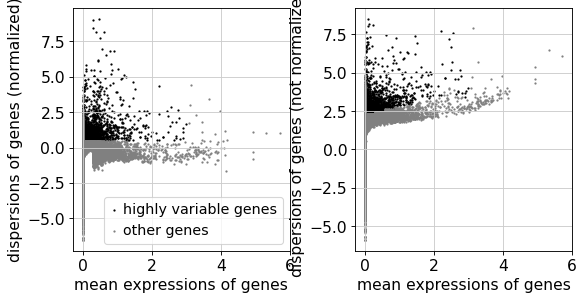

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [ ]:
# Feature Selection
%matplotlib inline

# Compute variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print('Highly variable genes: %d'%sum(adata.var.highly_variable))

# Plot variable genes
sc.pl.highly_variable_genes(adata)

# Scale
sc.pp.scale(adata, max_value=10)

computing PCA
    with n_comps=50
    finished (0:00:20)


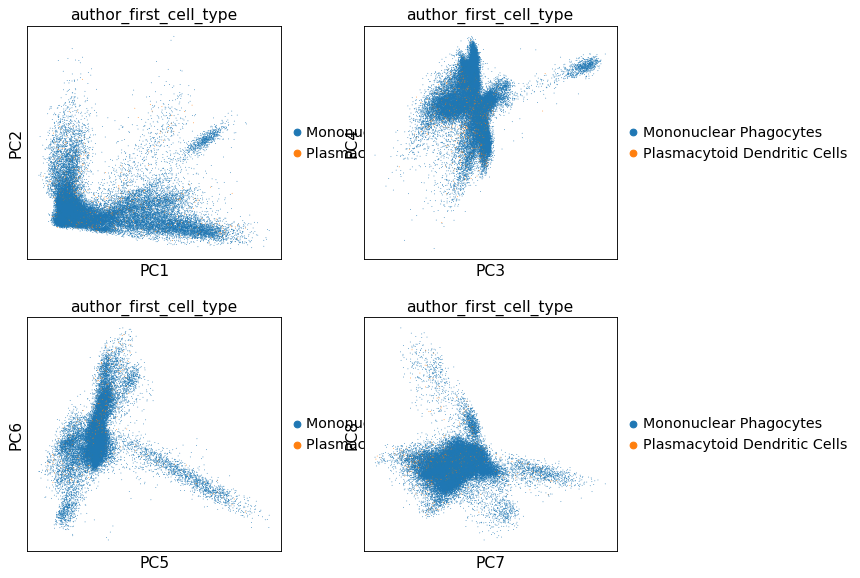

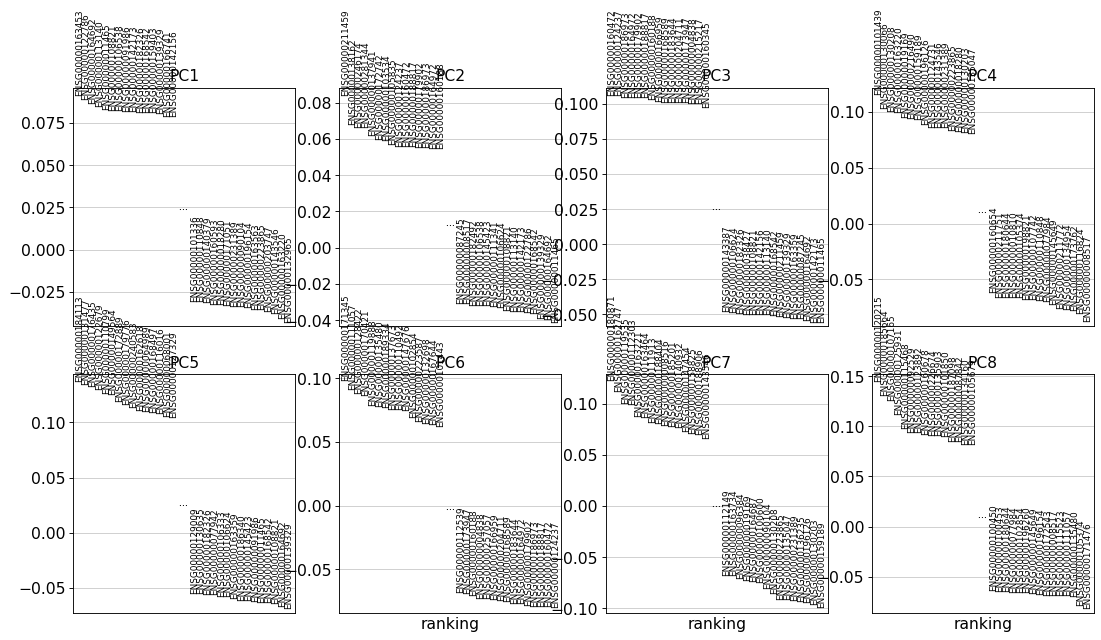

In [ ]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')

# Plot more PCS
sc.pl.pca(adata, color='author_first_cell_type', components = ['1,2' ,'3,4' ,'5,6' ,'7,8'], ncols=2)

# Plot loadings
sc.pl.pca_loadings(adata, components=[1, 2, 3, 4, 5, 6, 7, 8])

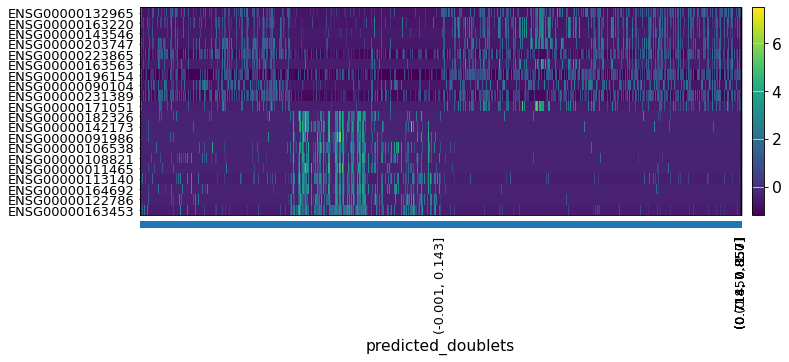

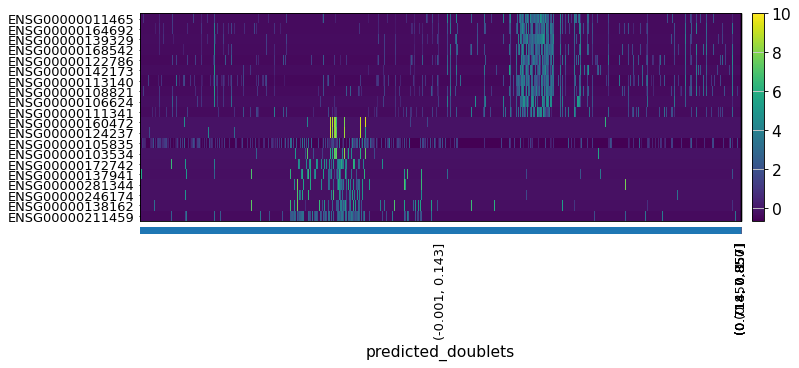

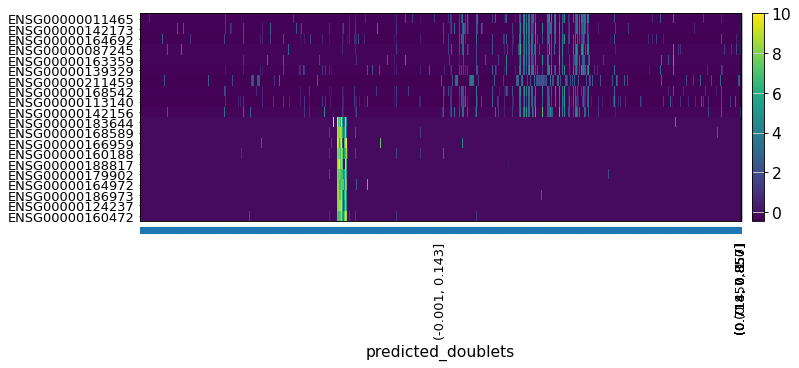

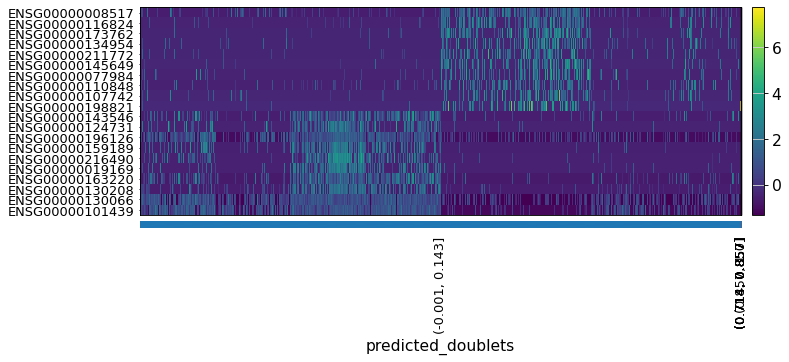

In [10]:
# adata.obsm["X_pca"] is the embeddings
# adata.uns["pca"] is pc variance
# adata.varm['PCs'] is the loadings

genes = adata.var['feature_name']

for pc in [1,2,3,4]:
    g = adata.varm['PCs'][:,pc-1]
    o = np.argsort(g)
    sel = np.concatenate((o[:10],o[-10:])).tolist()
    emb = adata.obsm['X_pca'][:,pc-1]
    # order by position on that pc
    tempdata = adata[np.argsort(emb),]
    sc.pl.heatmap(tempdata, var_names = genes[sel].index.tolist(), groupby='predicted_doublets', swap_axes = True, use_raw=False)

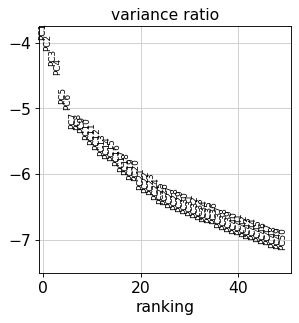

In [11]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm)
    'tsne', tSNE parameters (adata.uns) (0:02:21)


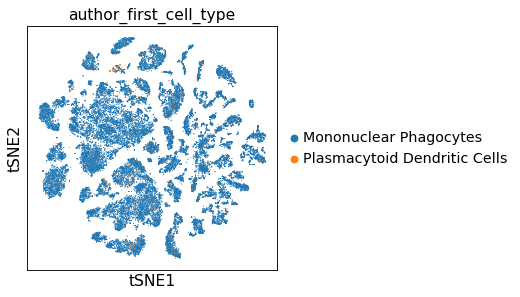

In [12]:
# tSNE
sc.tl.tsne(adata, n_pcs = 30)

sc.pl.tsne(adata, color='author_first_cell_type')

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:06)


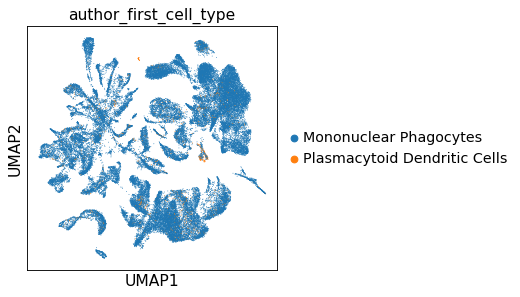

In [13]:
# UMAP
sc.pp.neighbors(adata, n_pcs = 30, n_neighbors = 20)

sc.tl.umap(adata)
sc.pl.umap(adata, color='author_first_cell_type')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:24)


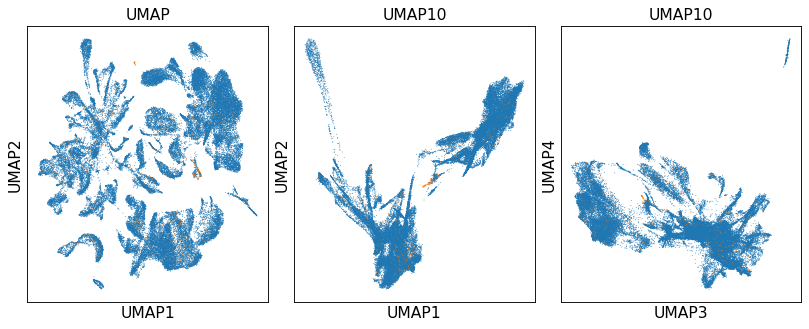

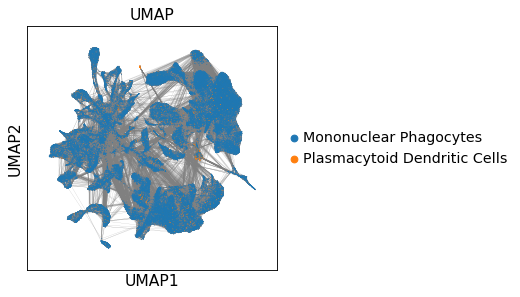

In [ ]:
# Run with 10 components
umap10 = sc.tl.umap(adata, n_components=10, copy=True)
fig, axs = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)

sc.pl.umap(adata, color='author_first_cell_type',  title='UMAP',
           show=False, ax=axs[0], legend_loc=None)
sc.pl.umap(umap10, color='author_first_cell_type', title='UMAP10', show=False,
           ax=axs[1], components=['1,2'], legend_loc=None)
sc.pl.umap(umap10, color='author_first_cell_type', title='UMAP10',
           show=False, ax=axs[2], components=['3,4'], legend_loc=None)

# Plot the umap with neighbor edges
sc.pl.umap(adata, color='author_first_cell_type', title="UMAP", edges=True)

<Axes: title={'center': 'author_first_cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

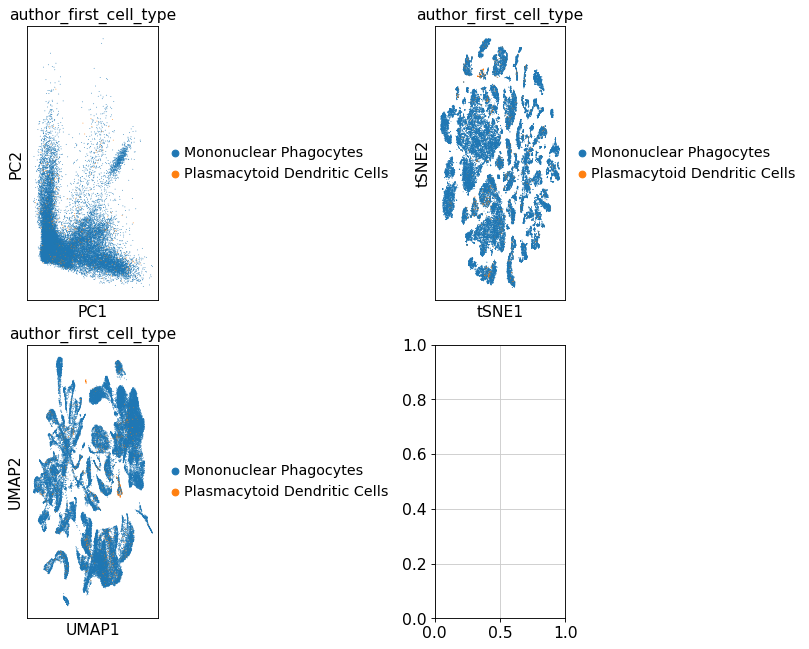

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
sc.pl.pca(adata, color='author_first_cell_type', components=['1,2'], ax=axs[0, 0], show=False)
sc.pl.tsne(adata, color='author_first_cell_type', components=['1,2'], ax=axs[0, 1], show=False)
sc.pl.umap(adata, color='author_first_cell_type', components=['1,2'], ax=axs[1, 0], show=False)

In [ ]:
# Genes of interest
# Convert the ENSEMBL IDs to the gene names
print(adata.var["feature_name"].head())  # Print first few gene names

# Gene Symbol → Ensembl ID
symbol_to_ensembl = dict(zip(adata.var["feature_name"], adata.var.index))

# List of your genes of interest
genes_of_interest = ['C1QB', 'C1QA', 'FCER1A', 'CD1C', 'FCN1', 'VCAN', 'CPA3', 'TPSAB1', 'ICAM1', 'CXCR2']

# Convert gene symbols to Ensembl IDs (only keep existing ones)
ensembl_ids = [symbol_to_ensembl[gene] for gene in genes_of_interest if gene in symbol_to_ensembl]

print('Mapped Ensembl IDs:', ensembl_ids)

Mapped Ensembl IDs: ['ENSG00000198851', 'ENSG00000010610', 'ENSG00000153563', 'ENSG00000115523', 'ENSG00000105374', 'ENSG00000156738', 'ENSG00000170458', 'ENSG00000090382', 'ENSG00000101439', 'ENSG00000166927', 'ENSG00000203747']


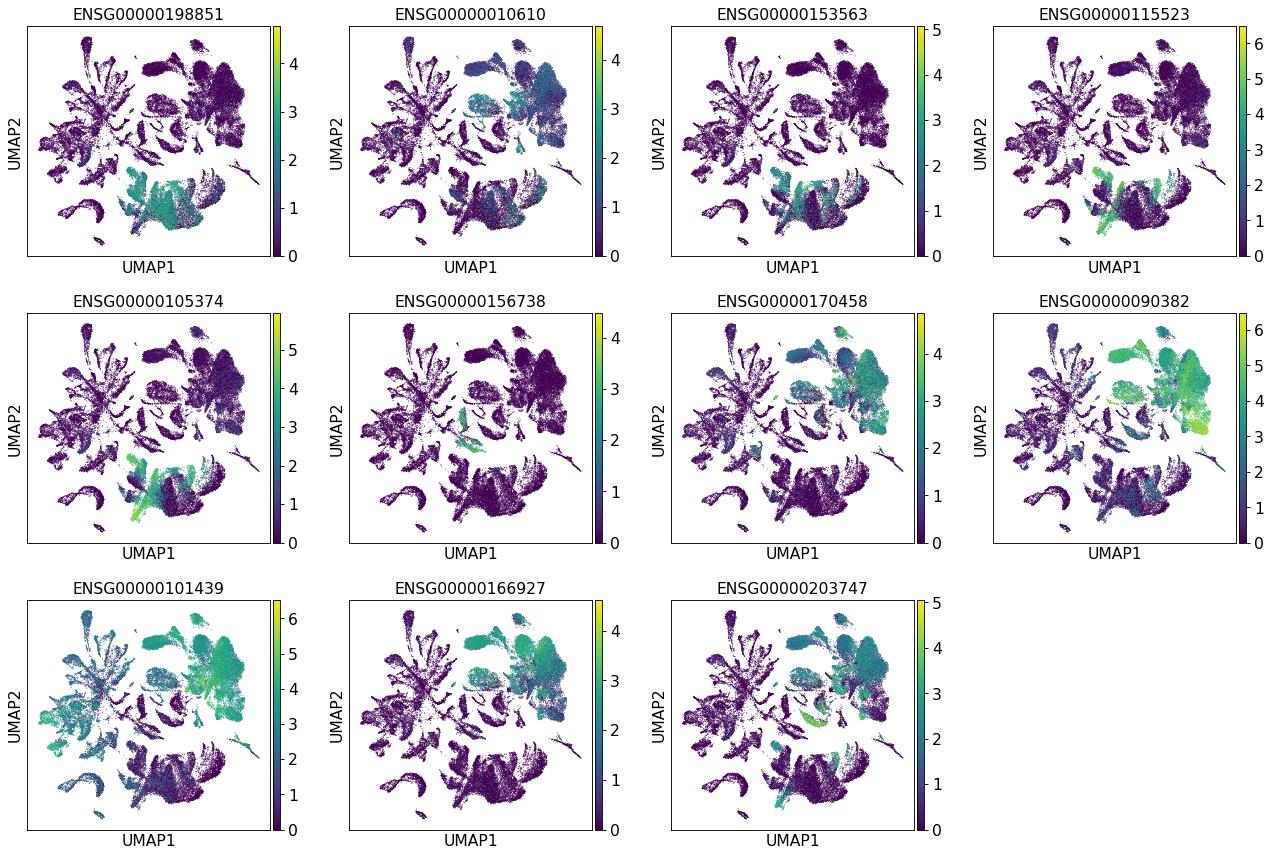

In [ ]:
# Genes of interest
sc.pl.umap(adata, color=ensembl_ids)

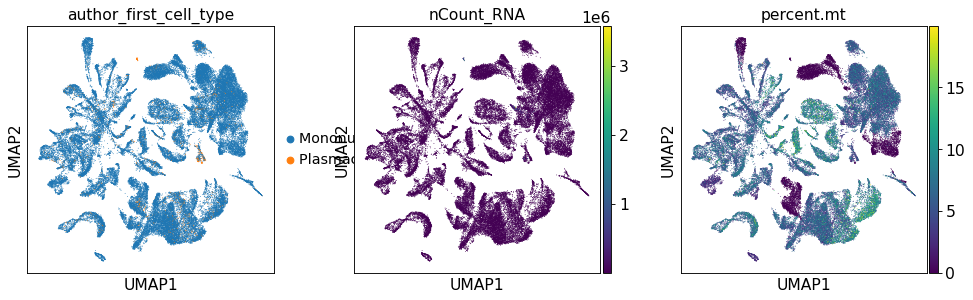

In [24]:
sc.pl.umap(adata, color=['author_first_cell_type', 'nCount_RNA', 'percent.mt'], ncols=3,use_raw=False)

In [ ]:
# Save the data
adata.write_h5ad('2_DimensionalityReduction/Data/Output/scanpy_dr_scAtlas.h5ad')